In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Sprint 1 - Strategic Store Expansion Using Household Debt Insights

In this project, we aim to uncover insights into the relationship between household debt to income ratio and the strategic decisions of store openings by Target.  While we don't have access to the performance data of existing stores, we can use economic information to identify regions with high potential for new store success. By analyzing household debt characteristics, we can recommend prime locations for Target's expansion.

Our key question is: How can household debt, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?

We will be using two datasets for this project:

1.   targets.csv - This dataset includes a record for Target locations currently in operation as of April 2017
2.   debt_county.csv - This dataset includes a record of the household debt to income ration since 1999

Let's begin the cleaning process for target.csv

### Data Inspection

In [3]:
raw_target_data = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/target.csv', encoding='latin1')
raw_target_data.head()

,X.locale,Address.AddressLine1,Address.AddressLine2,Address.City,Address.CountryName,Address.County,Address.FormattedAddress,Address.IntersectionDescription,Address.Latitude,Address.Longitude,...,Is24Hours.Sat,IsOpen.Sat,Summary.Sat,ThruTime.Sat,BeginTime.Sun,Is24Hours.Sun,IsOpen.Sun,Summary.Sun,ThruTime.Sun,AllCapability
0,en-US,400 Oxford Exchange Blvd,NaN,Oxford,United States,Calhoun,"400 Oxford Exchange Blvd, Oxford, AL 36203-3459",SEC I-20 & Golden Creek Rd,33.608825,-85.783182,...,False,True,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Star..."
1,en-US,2640 Enterprise Dr,NaN,Opelika,United States,Lee,"2640 Enterprise Dr, Opelika, AL 36801-1511",NWC I-85 & Hwy 280,32.618108,-85.410636,...,False,True,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'..."
2,en-US,1129 S Park St,NaN,Carrollton,United States,Carroll,"1129 S Park St, Carrollton, GA 30117-4429",NWC US 27 & Hwy 166 Bypass,33.558920,-85.076473,...,False,True,8:00 a.m.-10:00 p.m.,22:00:00,8:00:00,False,True,8:00 a.m.-9:00 p.m.,21:00:00,NaN
3,en-US,555 Bullsboro Dr,NaN,Newnan,United States,Coweta,"555 Bullsboro Dr, Newnan, GA 30265-1045",SWC I-85 & Rte 34,33.392907,-84.758875,...,False,True,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Fresh Grocery', 'Mob..."
4,en-US,1591 Bradley Park Dr,NaN,Columbus,United States,Muscogee,"1591 Bradley Park Dr, Columbus, GA 31904-3071",NEC Bradley Pk & JR Allen Pkwy,32.534649,-84.971073,...,False,True,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Phot..."


Here we can see the first 5 rows in our dataset and understand the formats of each column. In this dataset, there are 47 features that we need to examine to determine their relevance to our analysis.

In [4]:
raw_target_data.shape

(1829, 47)

Here we see that there are 1829 rows/stores. Let's check for duplicate values to ensure every row is unique.

In [5]:
raw_target_data.duplicated().sum()

0

We see that there are no duplicated, but to be sure let's ensure there are the same number of unique values as there are rows. This ensures there are no duplicate stores even if the row is not completely the same


In [6]:
raw_target_data.duplicated(subset=['Address.AddressLine1']).sum()

0

Here we see again that there are no duplicates in terms of addresses.

Let's now assess which columns are impactful to our analysis of answering our key question: How can household debt data, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?

First let's take a look at all of the columns.

In [7]:
raw_target_data.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.CountryName', 'Address.County',
       'Address.FormattedAddress', 'Address.IntersectionDescription',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'AlternateIdentifier.ID', 'ID',
       'IsDaylightSavingsTimeRecognized', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'OperatingHours..timeFormat', 'Store.StoreDistrictID',
       'Store.StoreGroupID', 'Store.StoreRegionID', 'SubTypeDescription',
       'TimeZone.TimeZoneCode', 'TimeZone.TimeZoneDescription',
       'TimeZone.TimeZoneOffset.OffsetCode',
       'TimeZone.TimeZoneOffset.OffsetHours', 'TypeCode', 'PhoneNumber',
       'FaxNumber', 'BeginTime.MF', 'Is24Hours.MF', 'IsOpen.MF', 'Summary.MF',
       'ThruTime.MF', 'BeginTime.Sat', 'Is24Hours.Sat', 'IsOpen.Sat',
       'Summary.Sat', 'ThruTime.Sat', 'BeginTime.Sun', 'Is24Hour

We see here many fields having to do with store open times. I will keep these variables in mind however at this time they are not relevant to our analysis so they will be dropped. I will explore remaining data later on in the notebook.

Irrelevant time fields will now be dropped.

In [8]:
# List of columns to drop
columns_to_drop = [
    'BeginTime.MF', 'Is24Hours.MF', 'IsOpen.MF', 'Summary.MF',
    'ThruTime.MF', 'BeginTime.Sat', 'Is24Hours.Sat', 'IsOpen.Sat',
    'Summary.Sat', 'ThruTime.Sat', 'BeginTime.Sun', 'Is24Hours.Sun',
    'IsOpen.Sun', 'Summary.Sun', 'ThruTime.Sun',
    'TimeZone.TimeZoneCode', 'TimeZone.TimeZoneDescription',
    'TimeZone.TimeZoneOffset.OffsetCode', 'OperatingHours..timeFormat',
    'TimeZone.TimeZoneOffset.OffsetHours'
]

# Drop the columns
raw_target_data_drop = raw_target_data.drop(columns=columns_to_drop)

#check for relevant columns
raw_target_data_drop.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.CountryName', 'Address.County',
       'Address.FormattedAddress', 'Address.IntersectionDescription',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'AlternateIdentifier.ID', 'ID',
       'IsDaylightSavingsTimeRecognized', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'Store.StoreDistrictID', 'Store.StoreGroupID', 'Store.StoreRegionID',
       'SubTypeDescription', 'TypeCode', 'PhoneNumber', 'FaxNumber',
       'AllCapability'],
      dtype='object')

Now that we've removed all irrelevant store operating hours columns we can begin to explore if the remaining columns are relevant and how relevant they are to our analysis. Off the bat features such as phone number, fax number, 'is day light savings recognized" are irrelevant so we will drop those.

In [9]:
# List of columns to drop
columns_to_drop2 = ['PhoneNumber', 'FaxNumber', 'IsDaylightSavingsTimeRecognized',
                    'Address.IntersectionDescription','Address.CountryName','AlternateIdentifier.ID','ID']

# Drop the columns
raw_target_data_drop.drop(columns=columns_to_drop2, inplace=True)

In [10]:


#Check Columns
raw_target_data_drop.columns


Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.County', 'Address.FormattedAddress',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'Store.StoreDistrictID', 'Store.StoreGroupID', 'Store.StoreRegionID',
       'SubTypeDescription', 'TypeCode', 'AllCapability'],
      dtype='object')

Now we have 24 columns left. We will now explore each column to understand if it's relevant to our analysis and how relevant it is to answering our question: How can household debt data, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?

### Column Cleaning

Let's analyze the number of null values in our datset

In [11]:
raw_target_data_drop.isnull().sum()

X.locale                                 0
Address.AddressLine1                     0
Address.AddressLine2                  1771
Address.City                             0
Address.County                           1
Address.FormattedAddress                 0
Address.Latitude                         0
Address.Longitude                        0
Address.PostalCode                       0
Address.Subdivision                      0
LocationMilestones.LastRemodelDate     395
LocationMilestones.OpenDate              0
Market                                  91
Name                                     0
Store.StoreDistrictID                    0
Store.StoreGroupID                       0
Store.StoreRegionID                      0
SubTypeDescription                    1522
TypeCode                                 0
AllCapability                           12
dtype: int64

In [12]:
raw_target_data['Name']

0                 Oxford
1                Opelika
2             Carrollton
3                 Newnan
4               Columbus
              ...       
1824           Stone Oak
1825       New Braunfels
1826          San Marcos
1827                Kyle
1828    Austin Southpark
Name: Name, Length: 1829, dtype: object

We've identified null values in several columns, including 'Address.AddressLine2' (1771 nulls), 'SubTypeDescription' (1522 nulls), 'LocationMilestones.LastRemodelDate' (395 nulls), 'Capabilities' (12 nulls), and 'Market' (91 nulls). These nulls may reflect non-remodeled locations or a lack of additional capabilities. Further analysis is needed to determine the most appropriate handling of these null values.

Let's start with Address Line 2

In [13]:
#explore address.line2
raw_target_data_drop['Address.AddressLine2'].unique()

array([nan, 'Ste 4000', 'Ste B', 'Ste 400', 'Ste 7', 'Ste 300', 'Ste 600',
       'Ste A', 'Ste 80', 'Ste 200', 'Ste 100', 'Ste 90', 'Ste F',
       'Ste 2400', 'Ste H', 'Ste 120', 'Ste 1', 'Ste 700', 'Ste 2250',
       'Ste Target', '#50', 'Ste F600', 'Suite 201', 'Ste 140', 'Ste 5',
       'Ste 121', 'Ste 110', 'Ste 1S', 'Ste 1900', 'Ste 49', 'STE 1',
       'Ste 201', 'Ste 500', 'Ste 101', 'Ste 102', 'Ste 2', 'Ste 42',
       'Bldg A100', 'Ste 1A', 'PO Box 5124', 'Ste. 100', 'Ste 125',
       'Ste G'], dtype=object)

Here we see the Adress Line 2 data. It's mostly unit numbers which are not very relevant to our analysis since we have the main address in another field. We can drop this column from the data.

In [14]:
#drop AddressLine2
raw_target_data_drop1 = raw_target_data_drop.drop('Address.AddressLine2', axis=1)

#check drop
raw_target_data_drop1.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Market', 'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability'],
      dtype='object')

Now we can explore the subtype description field

In [15]:
#explore subtype description

raw_target_data_drop1['SubTypeDescription'].unique()

array([nan, 'SuperTarget', 'TargetExpress', 'City'], dtype=object)

This columns' information might actually be interesting to analyze, it describes the type of Target that has been opened - 'SuperTarget', 'TargetExpress', or'City'. I can deal with the Nan values by webscraping or can assume that they are regular targets. For now I will assume that they are regular targets and map all nan values to 'Regular'

In [16]:
#replace all null values with 'Regular'
raw_target_data_drop1['SubTypeDescription'].fillna('Regular',inplace = True)


In [17]:
#check for no null values
raw_target_data_drop1['SubTypeDescription'].isnull().sum()

0

In [18]:
#check for unique values
raw_target_data_drop1['SubTypeDescription'].unique()

array(['Regular', 'SuperTarget', 'TargetExpress', 'City'], dtype=object)

We now see that there are no nulls in the SubTypeDescription column and all NaN have been replaced with 'Regular'

Now it's time to explore the X.locale column

In [19]:
#explore X.Locale
raw_target_data_drop1['X.locale'].unique()

array(['en-US'], dtype=object)

This column only contains 'en-US' meaning all locations are the same we can drop this column as it is redundant.

In [20]:
#drop x.locale
raw_target_data_drop2 = raw_target_data_drop1.drop('X.locale', axis=1)

#check drop
raw_target_data_drop2.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Market', 'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability'],
      dtype='object')

Now let's clean the LastRemodeled field. This field is important for analysis because I'd like to see if remodeling occurred because it can be a sign of Target re-investing which could indicate a successful store since we don't have sales/performance data.

In [21]:
#explore last remodeled field
raw_target_data_drop2['LocationMilestones.LastRemodelDate'].isna().sum()

395

We see that there are 395 nulls to handle. Because this field's nulls could mean that the Target wasnt remodeled we will create a new field with a binary indicator. Set it to 1 if 'LocationMilestones.LastRemodelDate' is not null and 0 otherwise.

In [22]:

# Create a binary indicator column
raw_target_data_drop2['Remodeled'] = pd.notna(raw_target_data['LocationMilestones.LastRemodelDate']).astype(int)

#check new column
raw_target_data_drop2[['LocationMilestones.LastRemodelDate','Remodeled']]


,LocationMilestones.LastRemodelDate,Remodeled
0,NaN,0
1,NaN,0
2,NaN,0
3,2013-06-27T12:00:00,1
4,2004-10-17T12:00:00,1
...,...,...
1824,NaN,0
1825,2013-06-27T12:00:00,1
1826,2009-03-04T12:00:00,1
1827,NaN,0


In [23]:
raw_target_data_drop2.shape

(1829, 19)

We can now see the Remodeled column ther 0's where there are NaNs and 1's where there are dates.



Let's convert the open date and last remodeled date column to pandas datetime in order to be able to use it for analysis later.

In [24]:
# Convert the columns to datetime format
raw_target_data_drop2['LocationMilestones.OpenDate'] = pd.to_datetime(raw_target_data_drop2['LocationMilestones.OpenDate'])
raw_target_data_drop2['LocationMilestones.LastRemodelDate'] = pd.to_datetime(raw_target_data_drop2['LocationMilestones.LastRemodelDate'])


In [25]:
raw_target_data_drop2[['LocationMilestones.OpenDate','LocationMilestones.LastRemodelDate']]

,LocationMilestones.OpenDate,LocationMilestones.LastRemodelDate
0,2006-07-19 12:00:00,NaT
1,2005-07-20 12:00:00,NaT
2,1997-07-23 12:00:00,NaT
3,1999-10-06 12:00:00,2013-06-27 12:00:00
4,1999-03-03 12:00:00,2004-10-17 12:00:00
...,...,...
1824,2007-07-25 12:00:00,NaT
1825,2008-07-23 12:00:00,2013-06-27 12:00:00
1826,2009-03-04 12:00:00,2009-03-04 12:00:00
1827,2009-10-07 12:00:00,NaT


Now let's explore the Market Column

In [26]:
raw_target_data_drop2['Market'].unique()

array(['ESE', 'ESF', nan, 'SFL', 'BTC', 'RG3', 'RG4', 'RG1', 'EMW', 'RG2',
       'ENE', 'SMA', 'RBO', 'RMI', 'SMN', 'RMP', "['GTM', 'RMP']", 'GTM'],
      dtype=object)

I was unable to find any documentation on what this field means so I will drop it.

In [27]:
raw_target_data_drop2.shape

(1829, 19)

In [28]:
#drop Market column
raw_target_data_drop3 = raw_target_data_drop2.drop('Market', axis = 1)

#check for clean data
raw_target_data_drop3.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability', 'Remodeled'],
      dtype='object')

Now let's explore 'All Capability'

In [29]:
raw_target_data_drop3['AllCapability']

0       ['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Star...
1       ['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...
2                                                     NaN
3       ['CVS pharmacy', 'Café', 'Fresh Grocery', 'Mob...
4       ['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Phot...
                              ...                        
1824    ['Bakery', 'CVS pharmacy', 'Cafe-Pizza', 'Deli...
1825    ['Accepts WIC', 'CVS pharmacy', 'Cafe-Pizza', ...
1826    ['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...
1827    ['CVS pharmacy', 'Cafe-Pizza', 'Drive Up', 'Fr...
1828    ['Accepts WIC', 'Bakery', 'CVS pharmacy', 'Caf...
Name: AllCapability, Length: 1829, dtype: object

We see that this field contains lists of additional features that a Target has such as a CVS, Cafe, Bakery etc. This could be useful for analysis. In order to process this I will create binary indicators for each unique value. First we need to explore what all of the unique value are

In [30]:


# Replace NaN values with an empty list
raw_target_data_drop3['AllCapability'].fillna('[]', inplace=True)



In [31]:
# Remove unwanted characters from the string and split the values into lists
raw_target_data_drop3['AllCapability'] = raw_target_data_drop3['AllCapability'].str.replace("[\[\]']", '', regex=True)
raw_target_data_drop3['AllCapability'] = raw_target_data_drop3['AllCapability'].str.split(', ')



In [32]:
# Assuming raw_target_data_drop3['AllCapability'] contains lists of capabilities
# Convert each list of capabilities into a string of comma-separated values
raw_target_data_drop3['AllCapability_str'] = raw_target_data_drop3['AllCapability'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Now use `str.get_dummies` which works on comma-separated strings to create one-hot encoding
capabilities_dummies = raw_target_data_drop3['AllCapability_str'].str.get_dummies(sep=',')

# Join the one-hot encoded DataFrame with the original DataFrame
raw_target_data_drop3 = raw_target_data_drop3.join(capabilities_dummies)

# You can drop the intermediate 'AllCapability_str' if it's no longer needed
raw_target_data_drop3.drop('AllCapability_str', axis=1, inplace=True)


In [33]:

# Drop the original 'AllCapability' column
raw_target_data_drop3.drop('AllCapability', axis=1, inplace=True)

In [34]:
raw_target_data_drop3.head()

,Address.AddressLine1,Address.City,Address.County,Address.FormattedAddress,Address.Latitude,Address.Longitude,Address.PostalCode,Address.Subdivision,LocationMilestones.LastRemodelDate,LocationMilestones.OpenDate,...,Optical,Photo Lab,Pizza Hut Salads and Snacks,Starbucks,Sun Boutique,Super Target,Which Wich Superior Sandwiches,Wine,Wine & Beer Available,Wine Available
0,400 Oxford Exchange Blvd,Oxford,Calhoun,"400 Oxford Exchange Blvd, Oxford, AL 36203-3459",33.608825,-85.783182,36203-3459,AL,NaT,2006-07-19 12:00:00,...,0,0,0,1,0,0,0,0,1,0
1,2640 Enterprise Dr,Opelika,Lee,"2640 Enterprise Dr, Opelika, AL 36801-1511",32.618108,-85.410636,36801-1511,AL,NaT,2005-07-20 12:00:00,...,0,0,0,1,0,0,0,0,1,0
2,1129 S Park St,Carrollton,Carroll,"1129 S Park St, Carrollton, GA 30117-4429",33.558920,-85.076473,30117-4429,GA,NaT,1997-07-23 12:00:00,...,0,0,0,0,0,0,0,0,0,0
3,555 Bullsboro Dr,Newnan,Coweta,"555 Bullsboro Dr, Newnan, GA 30265-1045",33.392907,-84.758875,30265-1045,GA,2013-06-27 12:00:00,1999-10-06 12:00:00,...,0,1,0,1,0,0,0,0,1,0
4,1591 Bradley Park Dr,Columbus,Muscogee,"1591 Bradley Park Dr, Columbus, GA 31904-3071",32.534649,-84.971073,31904-3071,GA,2004-10-17 12:00:00,1999-03-03 12:00:00,...,0,1,0,0,0,0,0,0,0,0


In [35]:
raw_target_data_drop3.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode', 'Remodeled',
       '"DAmico & Sons Italian Kitchen"', '& Spirits Available', 'Accepts WIC',
       'Bakery', 'Beauty Concierge', 'Beer', 'Beer Available', 'CVS pharmacy',
       'Cafe-Pizza', 'Café', 'Chobani Cafe',
       'Clinic care by Kaiser Permanente', 'Deli', 'Drive Up', 'Fresh Grocery',
       'In-Store Apple Store', 'MinuteClinic', 'Mobile Kiosk', 'Optical',
       'Photo Lab', 'Pizza Hut Salads and Snacks', 'Starbucks', 'Sun Boutique',
       'Super Target', 'Which Wich Superior Sandwiches', 'Wine',
       'Wine & Beer Available', 'Wine Available'],
      dtype='object')

We now see each Capability hot-encoded as a binary values

### Statistical Analysis

Let's explore the statistical distribution and possible correlations in this dataset. We'll start with a heat map of all numerical columns.

<ipython-input-36-664b269be1c7>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = raw_target_data_drop3[group].corr()


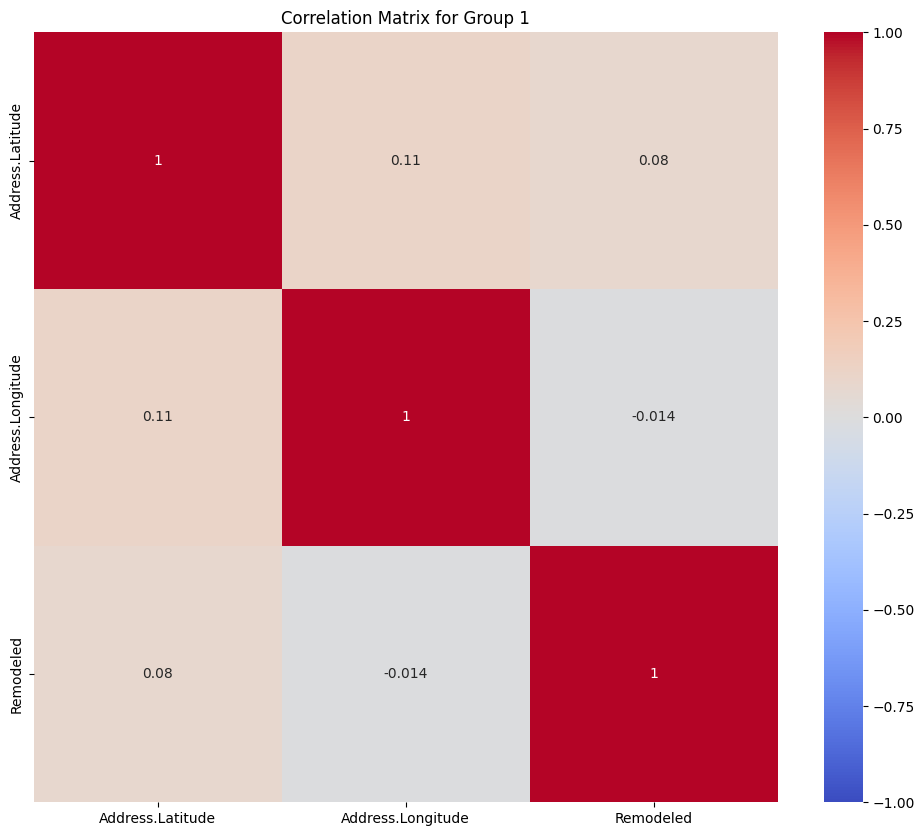

<ipython-input-36-664b269be1c7>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = raw_target_data_drop3[group].corr()


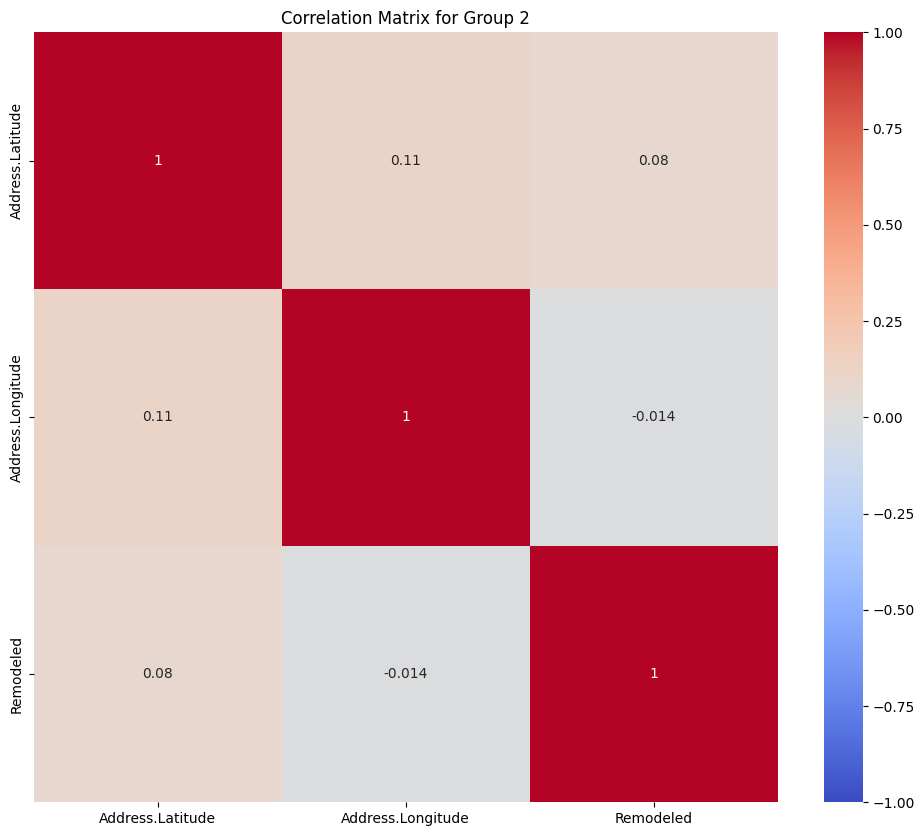

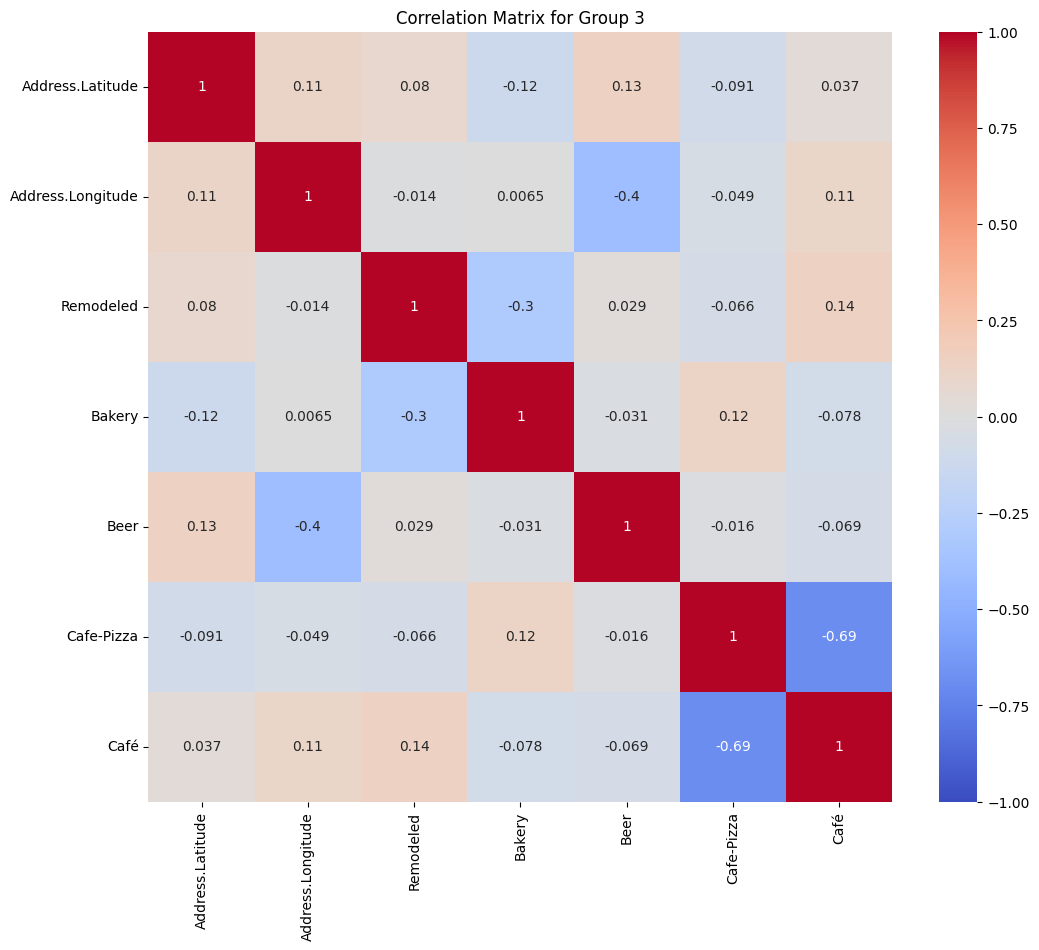

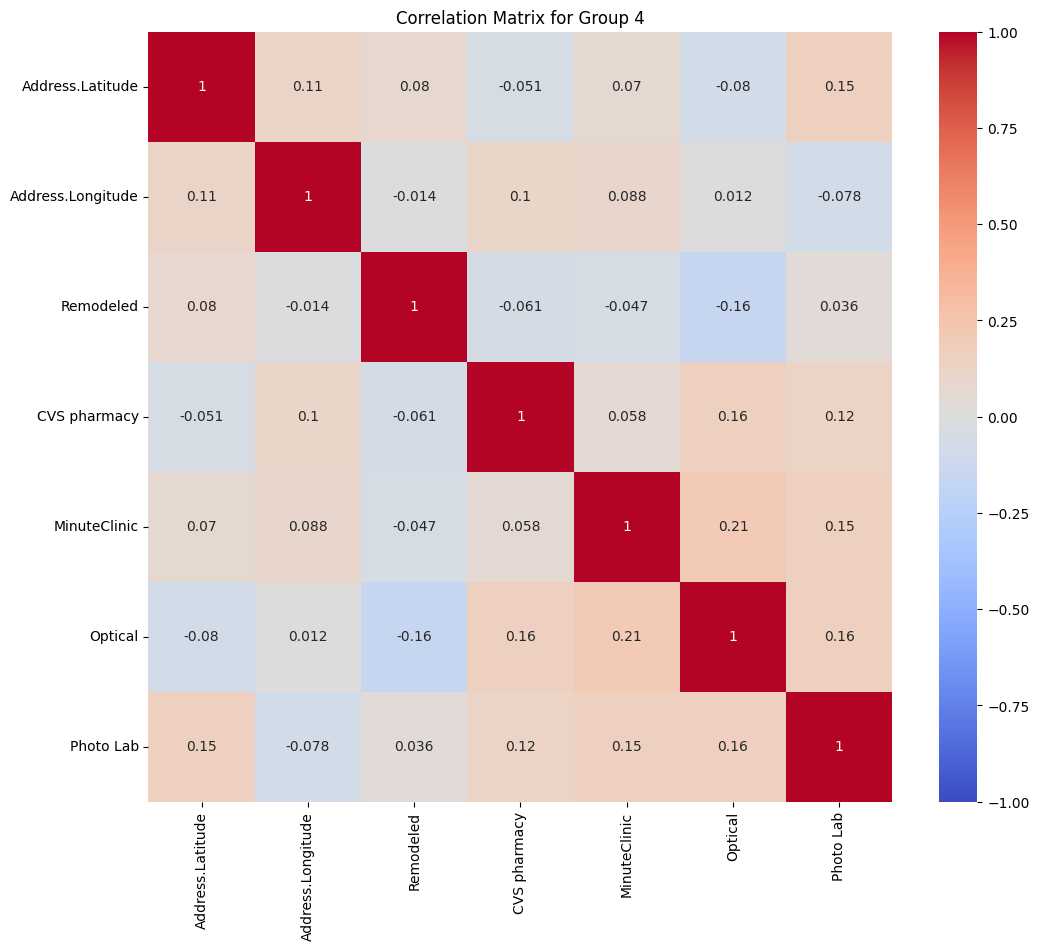

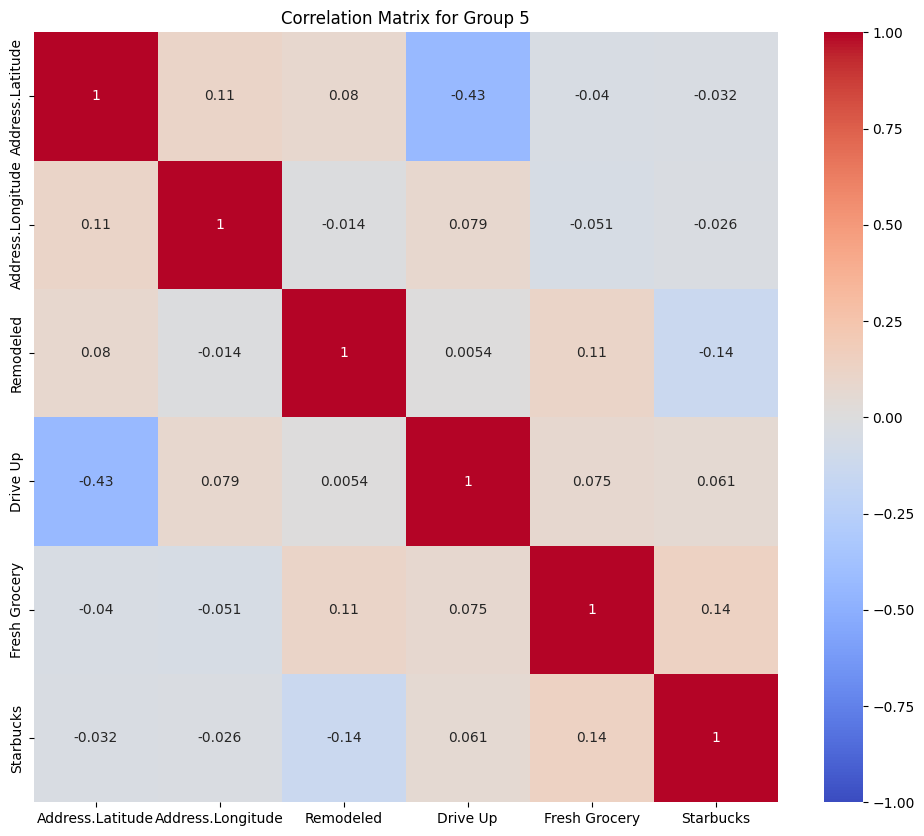

In [36]:
# Define column groups
groups = [
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Address.AddressLine1', 'Address.City', 'Address.County', 'Address.PostalCode'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Name'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Bakery', 'Beer', 'Cafe-Pizza', 'Café'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'CVS pharmacy', 'MinuteClinic', 'Optical', 'Photo Lab'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Drive Up', 'Fresh Grocery', 'Starbucks']
]

#Loop through each group to compute and display correlation matrix
for index, group in enumerate(groups, 1):
    correlation_matrix = raw_target_data_drop3[group].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for Group {index}")
    plt.show()


Upon examining the correlation matrix, we observe predominantly weak linear relationships between variables, hinting that they might largely function independently. This independence mitigates concerns about multicollinearity. However, these low correlations don't necessarily indicate an absence of relationships; non-linear interactions might be present but not reflected in the current metrics. While the initial impression suggests some variables might have lesser relevance due to their low correlation with the target, I will approach feature selection with a holistic view by exploring other types of relationships

###Histogram Analysis

Let's now plot histograms for each of the numeric columns

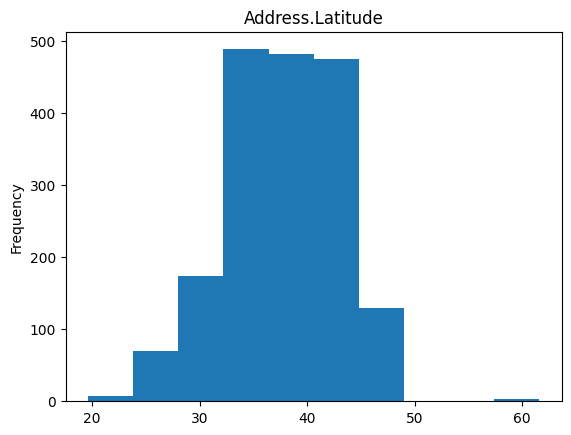

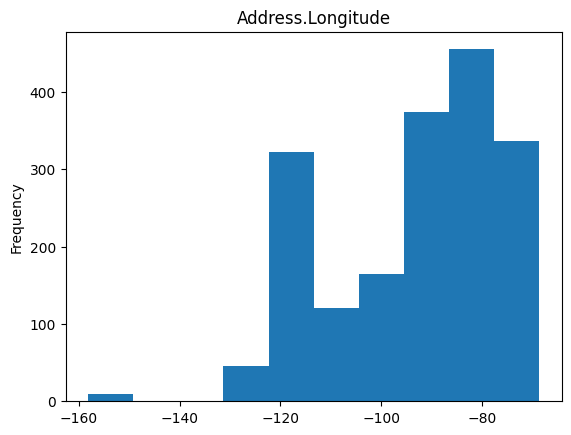

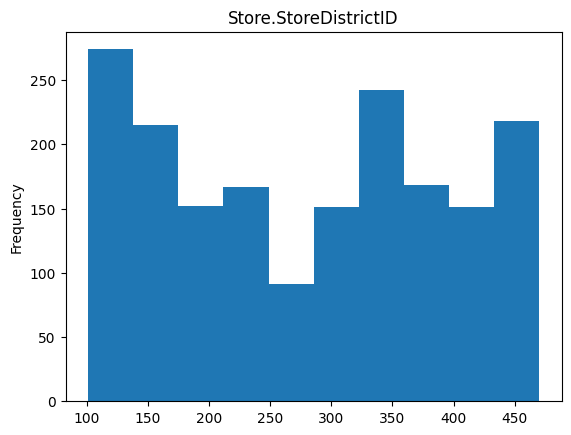

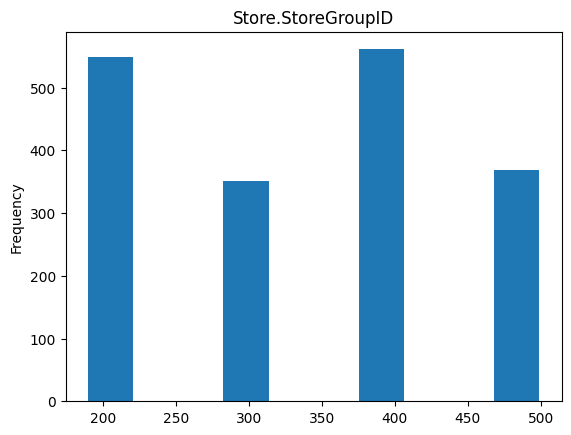

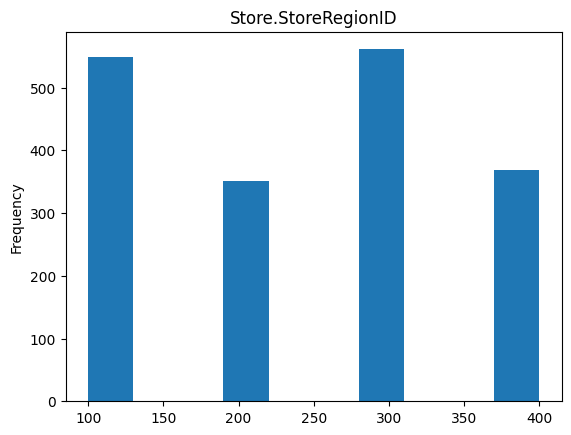

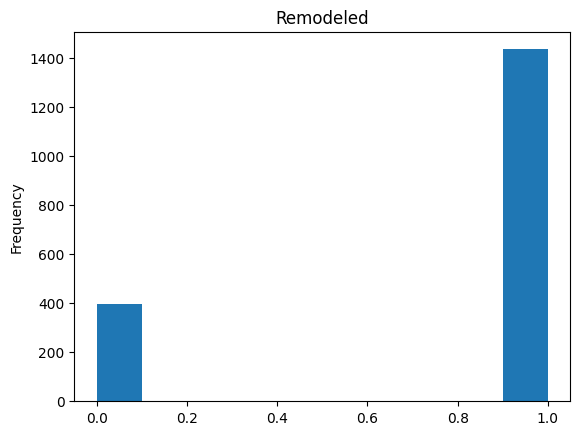

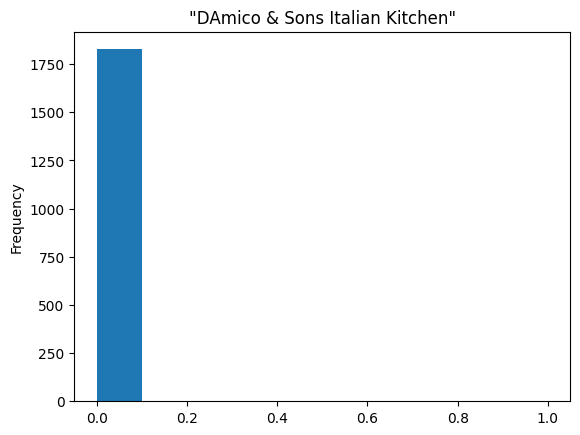

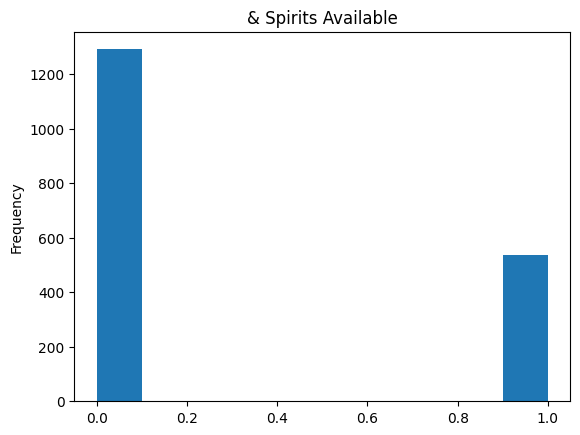

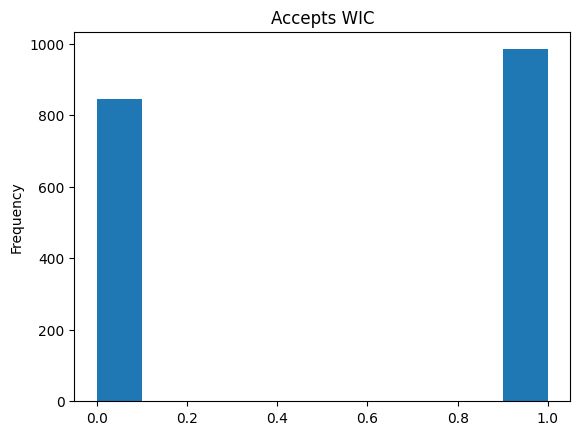

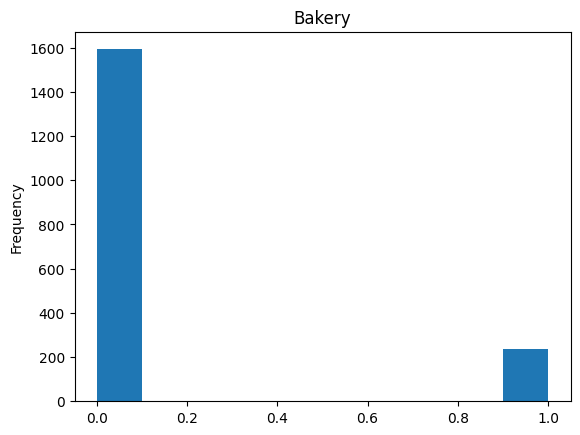

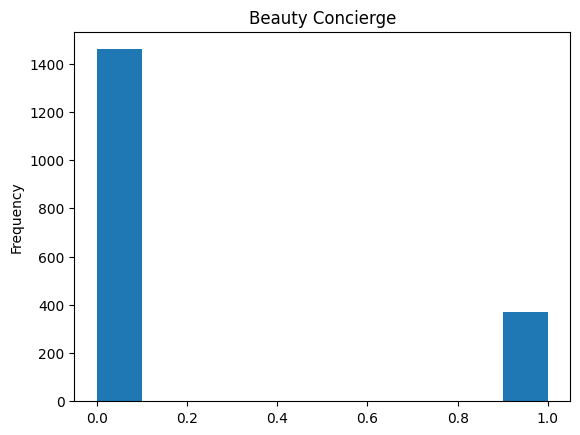

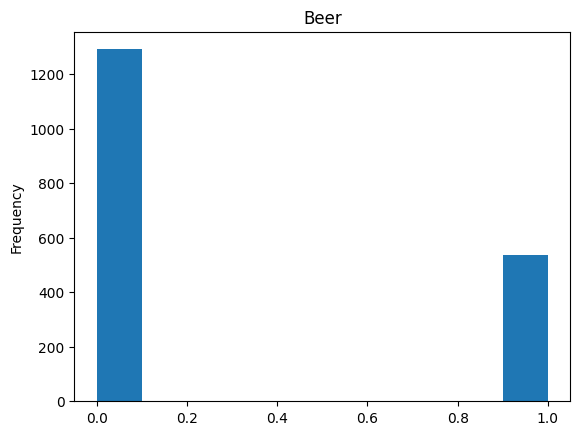

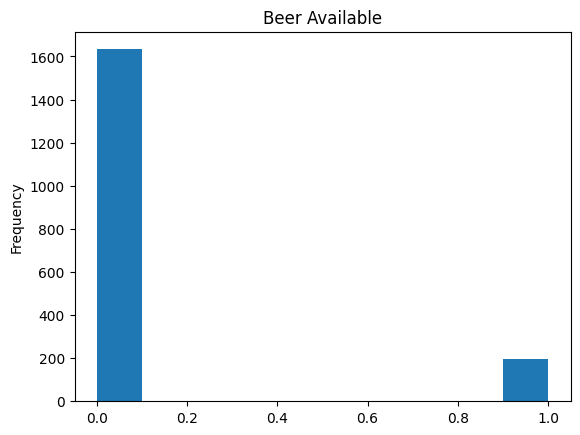

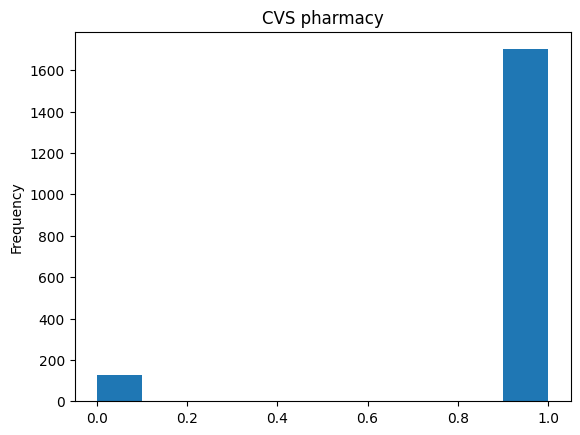

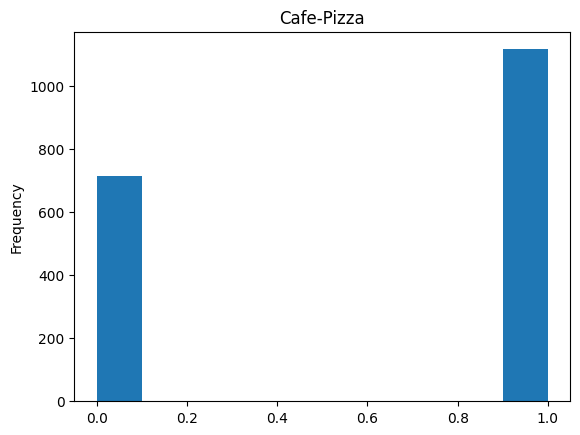

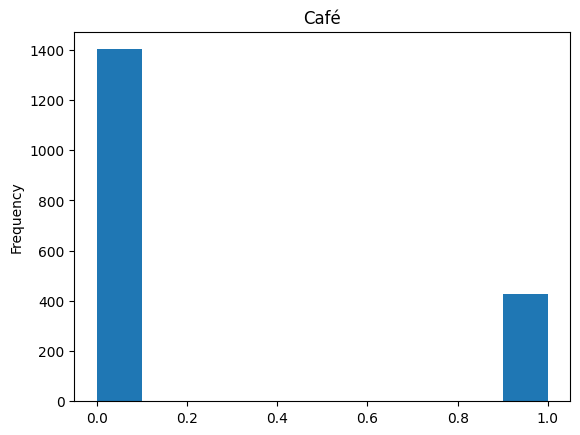

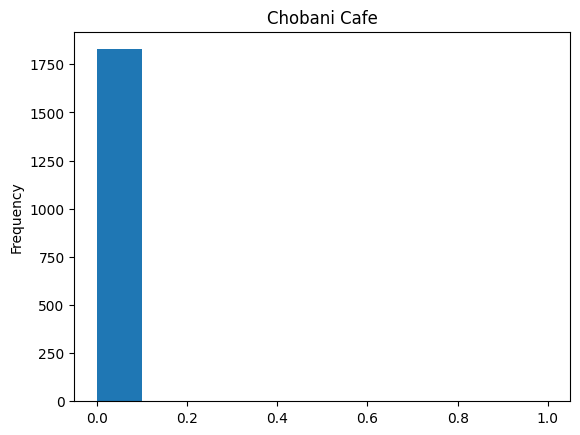

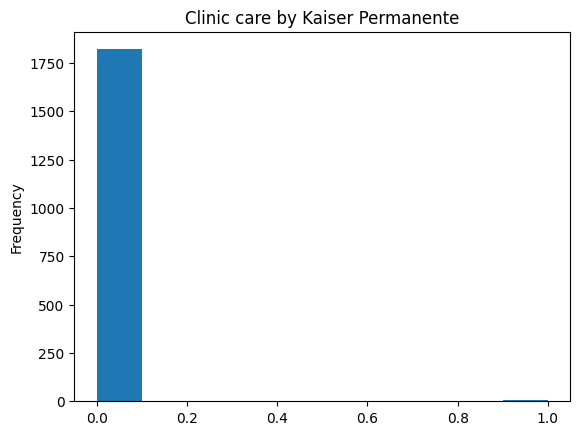

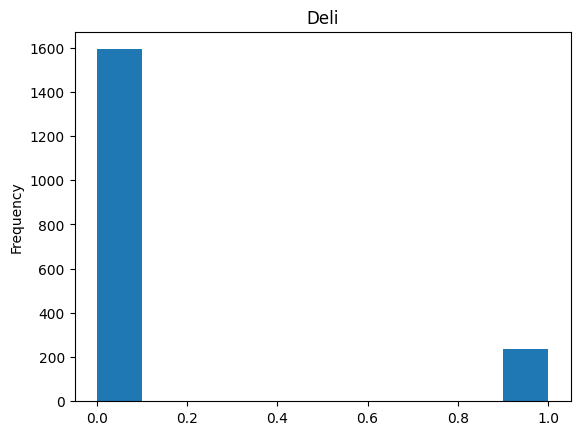

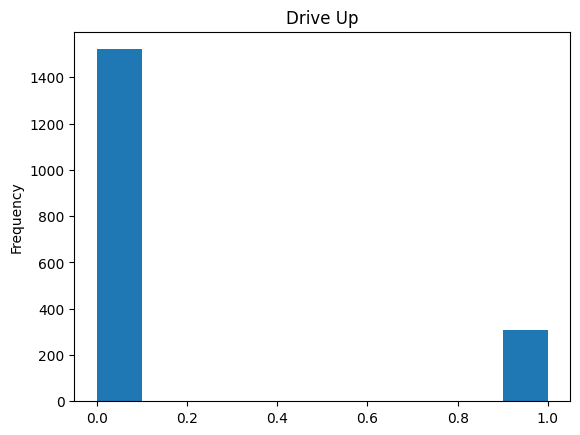

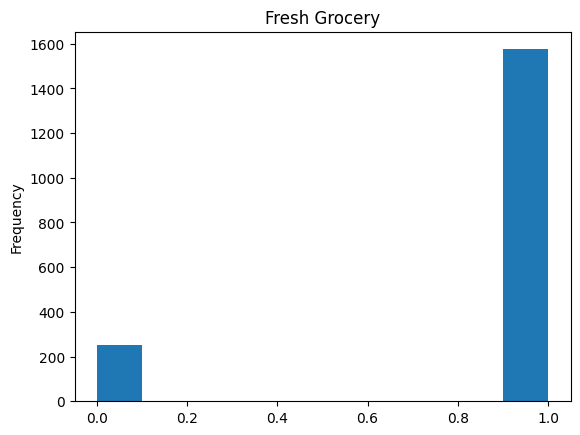

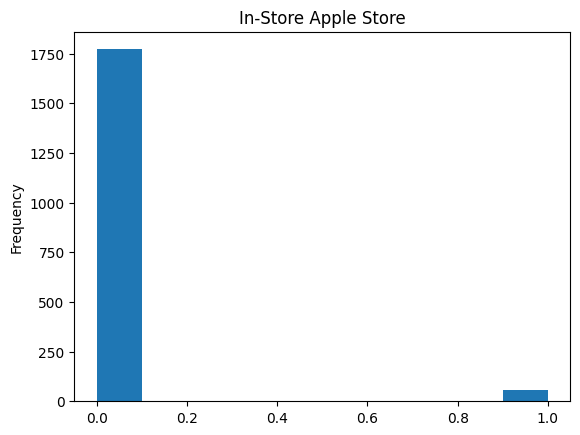

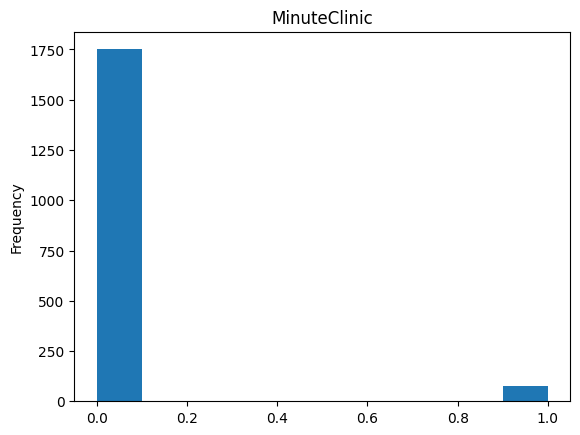

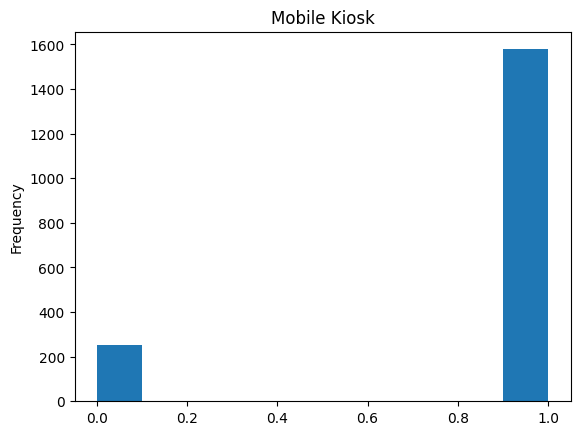

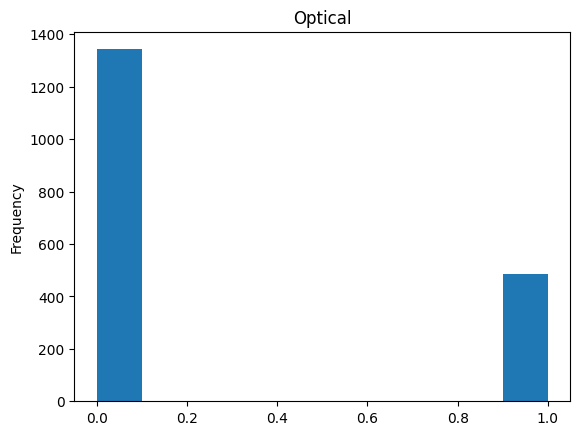

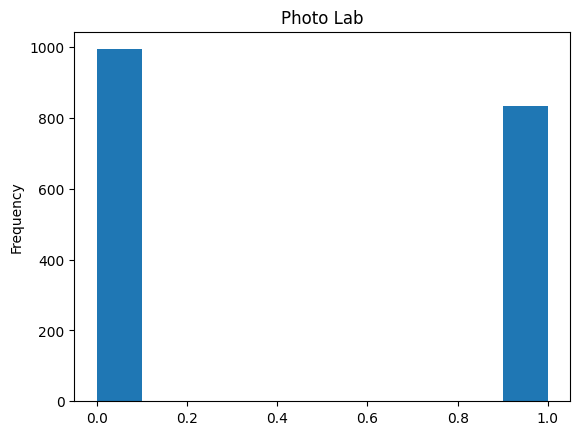

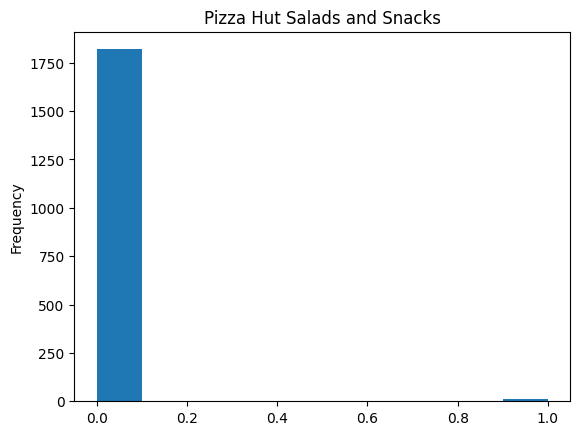

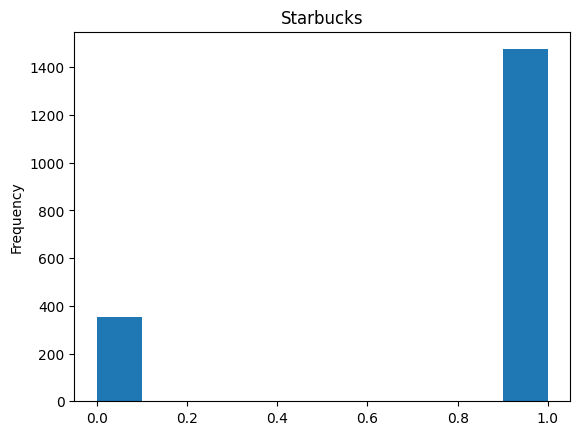

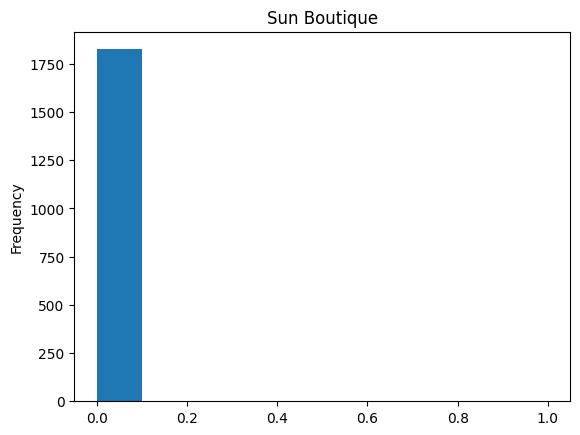

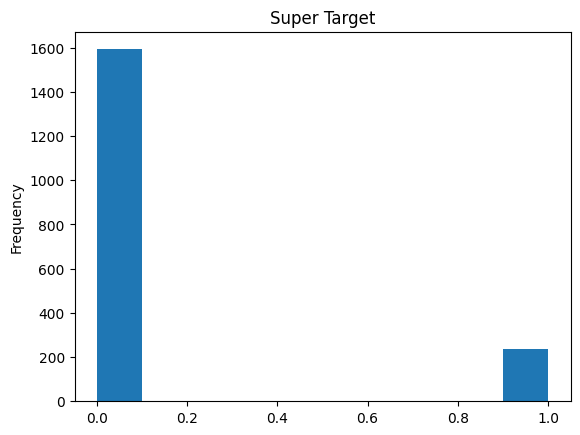

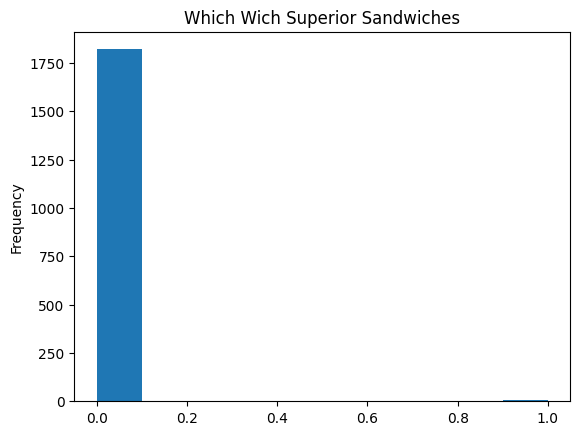

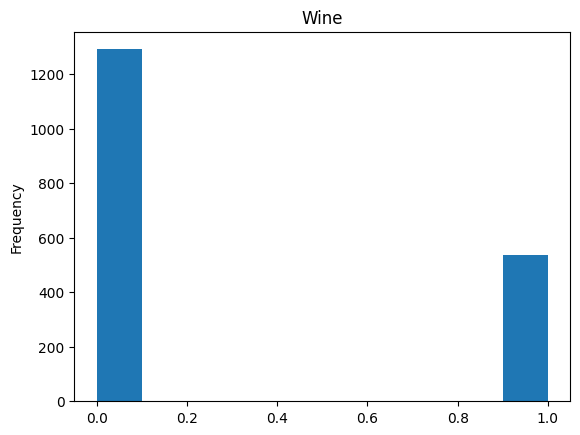

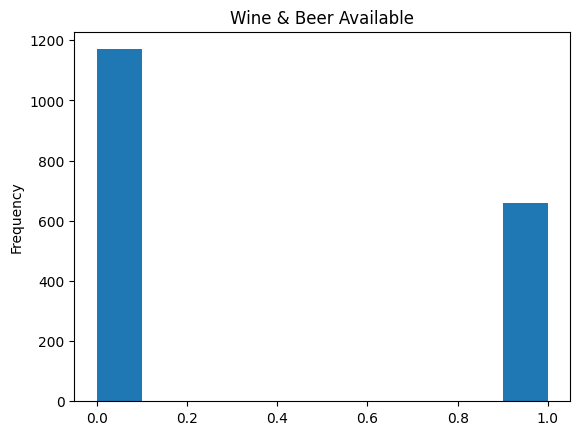

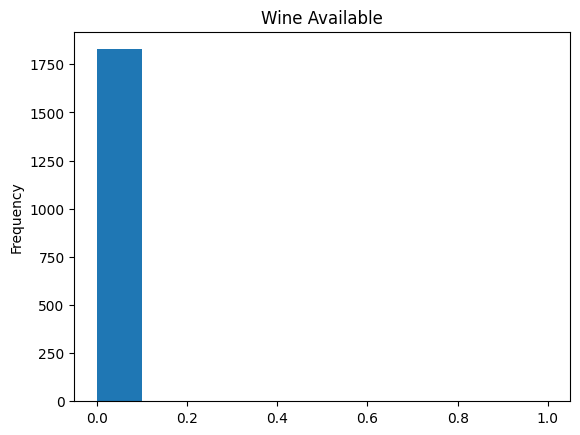

In [37]:
numeric_raw = raw_target_data_drop3.select_dtypes(include=['number'])

for col in numeric_raw.columns:
  numeric_raw.loc[:,col].plot(kind='hist')
  plt.title(col)
  plt.show()

###Analysis of Histograms

**Latitude and Longitude:**
The distribution of the latitude and longitude values appears to be normal. This suggests a fairly even distribution of Target stores across the regions under consideration. Visualizing these coordinates on a map or plotting them in a scatter plot could provide more granular insights about store distribution relative to geographical regions.

**Remodeled Stores:**
The data indicates a higher number of stores that have undergone remodeling compared to those that haven't. This is an intriguing observation, as it suggests that Target is keen on reinvesting in existing locations. It would be valuable to explore what types of neighborhoods or areas Target is choosing to reinvest in. Factors like neighborhood income, demographic changes, or local competition could influence such decisions.

**Capabilities:**
An initial glance at the histograms reveals that a significant number of stores lack certain capabilities. Understanding this trend could be crucial for strategic decisions. The absence of these capabilities might be indicative of older store models, regional preferences, or specific business strategies. Delving deeper into this data could help identify opportunities for store upgrades, features based on regional needs, or even potential expansion with newer store models in untapped regions

###Scatter Plot Analysis

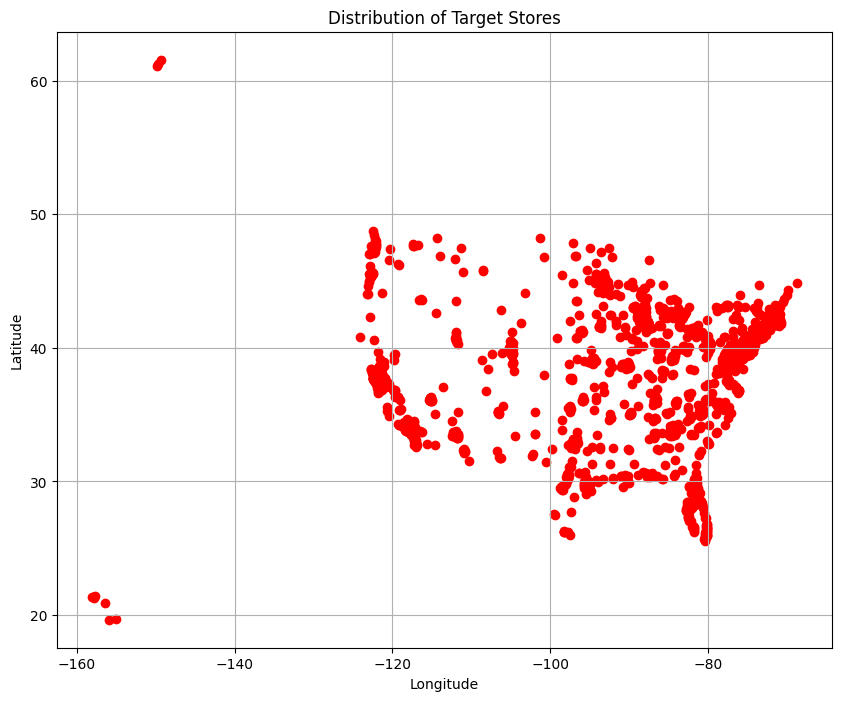

In [38]:
# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(raw_target_data_drop3['Address.Longitude'], raw_target_data_drop3['Address.Latitude'], c='red', marker='o')
plt.title("Distribution of Target Stores")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

### Analysis of the Geographic Distribution of Target Stores:

Upon plotting the latitude and longitude coordinates of each Target store, the scatter plot  shapes out a  silhouette resembling that of the USA. This geographic distribution provides us with several valuable insights:

**Broad Presence:** The distribution indicates that Target has a wide-reaching presence across the continental United States. The scattering of stores from coast to coast suggests a national strategy in place, aiming to cater to a diverse range of demographics and regional preferences.

**Density Variations:** While the scatter plot outlines the country, variations in the density of points indicate regions where Target has a stronger retail presence. Densely populated areas or economic hubs likely have a higher concentration of stores, signaling the company's strategic placement in locations with potentially higher foot traffic and purchasing power.

**Potential Gaps:** Conversely, areas with fewer points might represent regions with fewer Target outlets. These could either be regions that are less densely populated, or they could signify potential markets that Target has yet to tap into fully.

**Regional Strategies:** The distribution also prompts questions about regional strategies. For example, are there specific services or products that Target offers in coastal areas versus inland regions? Analyzing the store's offerings in conjunction with their locations could reveal tailored strategies for different parts of the country.

### Other Analysis


For my analysis of the Target dataset, I've been examining the relationships between the various columns to gain a deeper understanding. One of the techniques I considered using is Pearson's R, which measures how two variables might be related.

To effectively apply Pearson's R, it's crucial to distinguish between two types of variables: an independent one (which might influence outcomes) and a dependent one (which we observe for changes).

Currently, within the Target dataset, I haven't pinpointed a definitive independent variable. This means I'm still unsure about which factor could be influencing the others. Without this clarity, using Pearson's R could lead to conclusions that aren't well-founded.

Given this, I've decided to hold off on employing Pearson's R in my analysis. I believe it's essential to ensure that when I do use it, I can do so with confidence and precision.



### Debt to income ratio data

This dataset most likely needs to be scraped in order to get it into the correct format that I would need. Currently when downloading the data I receive it in the format below:

In [39]:
raw_debt_data = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/household-debt-by-county.csv')
raw_debt_data

,year,qtr,area_fips,low,high
0,1999,1,1001,1.82,2.15
1,1999,1,1003,1.82,2.15
2,1999,1,1005,0.00,0.78
3,1999,1,1007,2.61,3.43
4,1999,1,1009,2.15,2.61
...,...,...,...,...,...
304401,2023,1,56037,1.01,1.19
304402,2023,1,56039,0.78,1.01
304403,2023,1,56041,1.19,1.37
304404,2023,1,56043,1.82,2.15


This dataset provides a snapshot of a specific economic metric across various counties for the first quarter of 1999. Each entry corresponds to a county, identified by its Federal Information Processing Standards (FIPS) code, such as 1001 for Autauga, Alabama. The "low" and "high" columns present a range for the metric in question, offering insights into the economic variance within each county during this period.


To make better use of this data, I'll need to match the unique code (FIPS) with the actual county names. The website has the right format, but I can't download it directly. So, I'll be using webscraping to get this data. The data and format can be seen here- https://www.federalreserve.gov/releases/z1/dataviz/household_debt/county/table/

Webscraping is my next step and that will be completed in future sprints.

###Overall Next Steps


The next phase of my analysis will start with data collection. I plan to use web scraping techniques to extract household debt data from federalreserve.gov. My priority is to ensure that this newly acquired data integrates seamlessly with the cleaned Target dataset I already have. Once I secure both datasets, I'll begin the integration process. Here, my goal will be to merge the Target dataset with the household debt data, making sure to address and resolve any discrepancies for consistent and accurate analysis.

Following the integration, I'll venture into feature engineering. I aim to craft relevant features drawn from my initial insights. Potential features might include changes in the debt-to-income ratio over certain intervals or gauging the proximity of Target stores to their competitors.

Then, I'll shift my focus to modeling and analysis. I intend to use linear and logistic regression as a starting point to grasp the baseline dynamics and pinpoint significant predictors. To tease out the more intricate patterns in the data, especially the non-linear relationships and interactions between features, I'll deploy the Random Forest algorithm. I'll also use K-means clustering to categorize similar data points and employ mapping techniques for a visual representation of data patterns.

Concluding the analysis, I'll make predictions and carve out a strategy. Using my models, I aspire to predict the most promising locations for Target stores. Based on the insights from these models, I'll forge actionable strategies, such as identifying the best regions for new stores and spotlighting areas that might undergo notable financial shifts.

## Sprint 2

The objectives for this sprint are as follows:



1. Adjust feedback from last sprint  
2. Clean and run EDA on Debt by County Dataset
3. Run baseline time series modeling
5. Evaluate the model


Before we begin I want to note that I made some adjustments to my Sprint 1. I added back some columns that I dropped since learning that it is not best practice to drop columns during EDA. I also found that I ended up needing some columns such as Formatted Address.

### Pre-merge Processing


If we remember from last sprint we are attempting to merge two datasets (1) a list of target locations/features and (2) household debt to income per county and quarter.

Let's explore both datasets to better understand how we might merge them.



In [40]:
raw_target_data_drop3.head()

,Address.AddressLine1,Address.City,Address.County,Address.FormattedAddress,Address.Latitude,Address.Longitude,Address.PostalCode,Address.Subdivision,LocationMilestones.LastRemodelDate,LocationMilestones.OpenDate,...,Optical,Photo Lab,Pizza Hut Salads and Snacks,Starbucks,Sun Boutique,Super Target,Which Wich Superior Sandwiches,Wine,Wine & Beer Available,Wine Available
0,400 Oxford Exchange Blvd,Oxford,Calhoun,"400 Oxford Exchange Blvd, Oxford, AL 36203-3459",33.608825,-85.783182,36203-3459,AL,NaT,2006-07-19 12:00:00,...,0,0,0,1,0,0,0,0,1,0
1,2640 Enterprise Dr,Opelika,Lee,"2640 Enterprise Dr, Opelika, AL 36801-1511",32.618108,-85.410636,36801-1511,AL,NaT,2005-07-20 12:00:00,...,0,0,0,1,0,0,0,0,1,0
2,1129 S Park St,Carrollton,Carroll,"1129 S Park St, Carrollton, GA 30117-4429",33.558920,-85.076473,30117-4429,GA,NaT,1997-07-23 12:00:00,...,0,0,0,0,0,0,0,0,0,0
3,555 Bullsboro Dr,Newnan,Coweta,"555 Bullsboro Dr, Newnan, GA 30265-1045",33.392907,-84.758875,30265-1045,GA,2013-06-27 12:00:00,1999-10-06 12:00:00,...,0,1,0,1,0,0,0,0,1,0
4,1591 Bradley Park Dr,Columbus,Muscogee,"1591 Bradley Park Dr, Columbus, GA 31904-3071",32.534649,-84.971073,31904-3071,GA,2004-10-17 12:00:00,1999-03-03 12:00:00,...,0,1,0,0,0,0,0,0,0,0


In [41]:
raw_debt_data.head()

,year,qtr,area_fips,low,high
0,1999,1,1001,1.82,2.15
1,1999,1,1003,1.82,2.15
2,1999,1,1005,0.00,0.78
3,1999,1,1007,2.61,3.43
4,1999,1,1009,2.15,2.61


Inorder to merge these two datasets we will need to connect on various different fields. Our key question is 'How can household debt, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?'

In order to see this accurately we will need to merge the data not only in the right place (location), but the right time (date).

**Merging on Location**
In our household debt to income data we have a FIPS code, in order to use this we will need to convert these codes to match the Target dataset which has zipcode & county name. We will do this my using an intermediary dataset that will help us match the code to the county name & zipcode which is in the Target dataset.

**Merging on Date**
In our household debt to income data we are given Quarters rather than specfic dates. This means we will need to convert the Target dates into Quarters in order to merge.

### Cleaning House Hold Debt Data

Let's first clean and perform EDA on the household debt dataset

In [42]:
raw_debt_data.head()

,year,qtr,area_fips,low,high
0,1999,1,1001,1.82,2.15
1,1999,1,1003,1.82,2.15
2,1999,1,1005,0.00,0.78
3,1999,1,1007,2.61,3.43
4,1999,1,1009,2.15,2.61


Looking at the data we have the date which is the first date of the quarter, the year, the quarter and the area FIPS code. We also have low and high from my research lower debt to income ratio means

**Low:** This value likely signifies the lower boundary or provides an estimate of the minimal debt carried by households within the area. When the low value is relatively small, it may imply that a portion of the population has debt levels that could be considered manageable within the scope of the dataset.

**High:** In contrast, this value is presumed to reflect the upper boundary or an estimate of the greatest amount of debt held by households in the area. When the high value is substantial, it suggests the presence of a subset of the population whose debt levels reach the uppermost range captured by the data.

Smaller amounts of household debt might suggest a lower likelihood of financial duress among households, while larger debt amounts may indicate a higher potential for financial stress. I'm curious to see how this relates to where Target stores are located.

Let's get a high level understanding of the data

In [43]:
raw_debt_data.shape

(304406, 5)

In [44]:
raw_debt_data.duplicated().sum()

0

In [45]:
raw_debt_data.isnull().sum()

year             0
qtr              0
area_fips        0
low              0
high         30101
dtype: int64

In [46]:
raw_debt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304406 entries, 0 to 304405
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       304406 non-null  int64  
 1   qtr        304406 non-null  int64  
 2   area_fips  304406 non-null  int64  
 3   low        304406 non-null  float64
 4   high       274305 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 11.6 MB


We see a considerable amount of nulls in the high column, we also see that year and quarter are of the type int64 however we will need date time column for our analysis. We will create a datetime column and then look into the nulls.


In [47]:
# Convert 'year' and 'qtr' into datetime format
raw_debt_data['date'] = pd.to_datetime(raw_debt_data['year'].astype(str) + 'Q' + raw_debt_data['qtr'].astype(str))

Let's further investigate the nulls

In [48]:
raw_debt_data.loc[raw_debt_data['high'].isnull()]

,year,qtr,area_fips,low,high,date
81,1999,1,2170,3.43,NaN,1999-01-01
161,1999,1,5105,3.43,NaN,1999-01-01
185,1999,1,6003,3.43,NaN,1999-01-01
188,1999,1,6009,3.43,NaN,1999-01-01
192,1999,1,6017,3.43,NaN,1999-01-01
...,...,...,...,...,...,...
304251,2023,1,53069,3.43,NaN,2023-01-01
304274,2023,1,54037,3.43,NaN,2023-01-01
304287,2023,1,54063,3.43,NaN,2023-01-01
304336,2023,1,55051,3.43,NaN,2023-01-01


We see that all of the nulls in high have 3.43 in the low this leads me to believe that this ratio may represent the upper limit of household debt as reported by the Federal Reserve. We will handle the high nulls by filling them with 3.43 (the low value)

In [49]:
raw_debt_data['high'].fillna(raw_debt_data['low'], inplace=True)

In [50]:
raw_debt_data.isnull().sum()

year         0
qtr          0
area_fips    0
low          0
high         0
date         0
dtype: int64

### Statistical Analysis

Now that we've cleaned the data. Let's do a quick statistical analysis on the dataset

In [51]:
statistical_summary = raw_debt_data.describe()
statistical_summary

,year,qtr,area_fips,low,high
count,304406.000000,304406.000000,304406.000000,304406.000000,304406.000000
mean,2010.630592,2.484491,30400.542552,1.593909,1.936550
std,7.000343,1.122515,15151.665576,0.919289,0.901272
min,1999.000000,1.000000,1001.000000,0.000000,0.780000
25%,2005.000000,1.000000,18181.000000,1.010000,1.190000
50%,2011.000000,2.000000,29177.000000,1.580000,1.820000
75%,2017.000000,3.000000,45081.000000,2.150000,2.610000
max,2023.000000,4.000000,56045.000000,3.430000,3.430000


In summary, the dataset shows a wide spread of household debt across many counties over two decades. The debt levels, as indicated by the low and high values, show considerable variability but tend to be more densely packed at the lower end of the scale. There is no indication of significant outliers in the high values, as the maximum high is equal to the maximum low, suggesting that in some counties, the range of debt is not broad. The fact that the 75th percentile of high values is less than the maximum (3.43) suggests that only a small proportion of counties have debt levels at the upper extreme.


Let's better understand the distribution of the data.

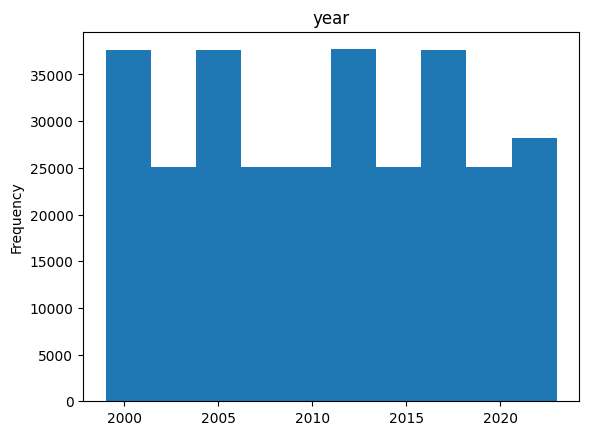

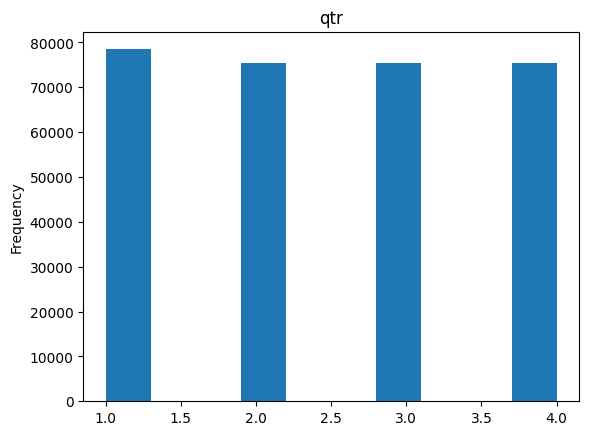

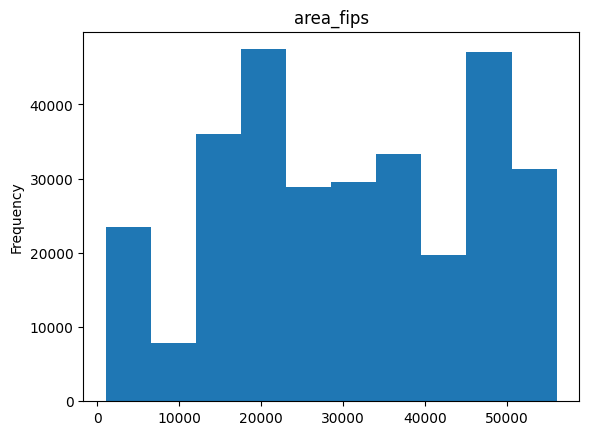

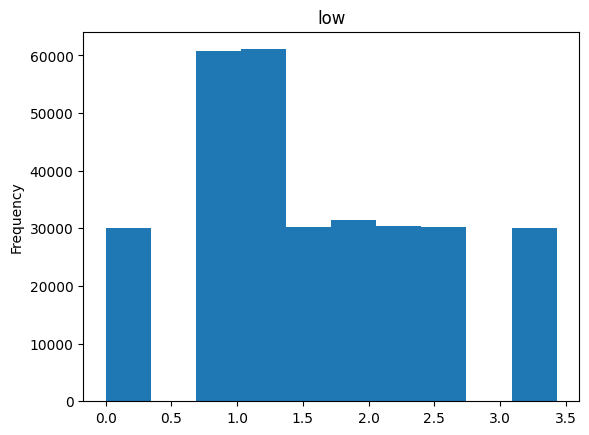

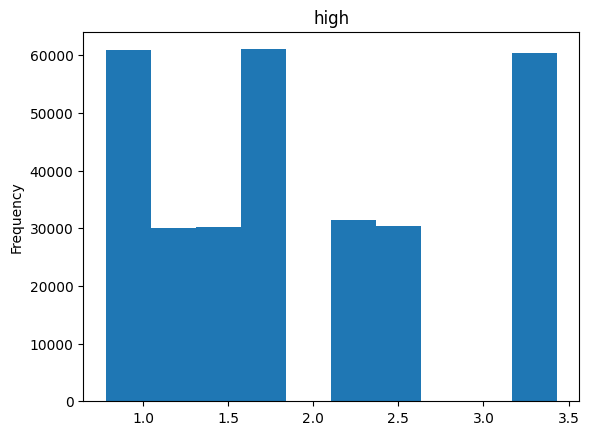

In [52]:
numeric_debt_data = raw_debt_data.select_dtypes(include=['float64', 'int64'])


for col in numeric_debt_data.columns:
  numeric_debt_data.loc[:,col].plot(kind='hist')
  plt.title(col)
  plt.show()

Here we can see the distribution of our data I'll focus mostly on the high and low columns.

**Low** We see that we have data mostly distributed towards the middle and lower end of the scale with a peak ratio around 1.0

**High** Here we also see that the distribution mostly packed on the low end. We also see a surge around 3.4 because of the nulls that we filled.

### Trend Analysis

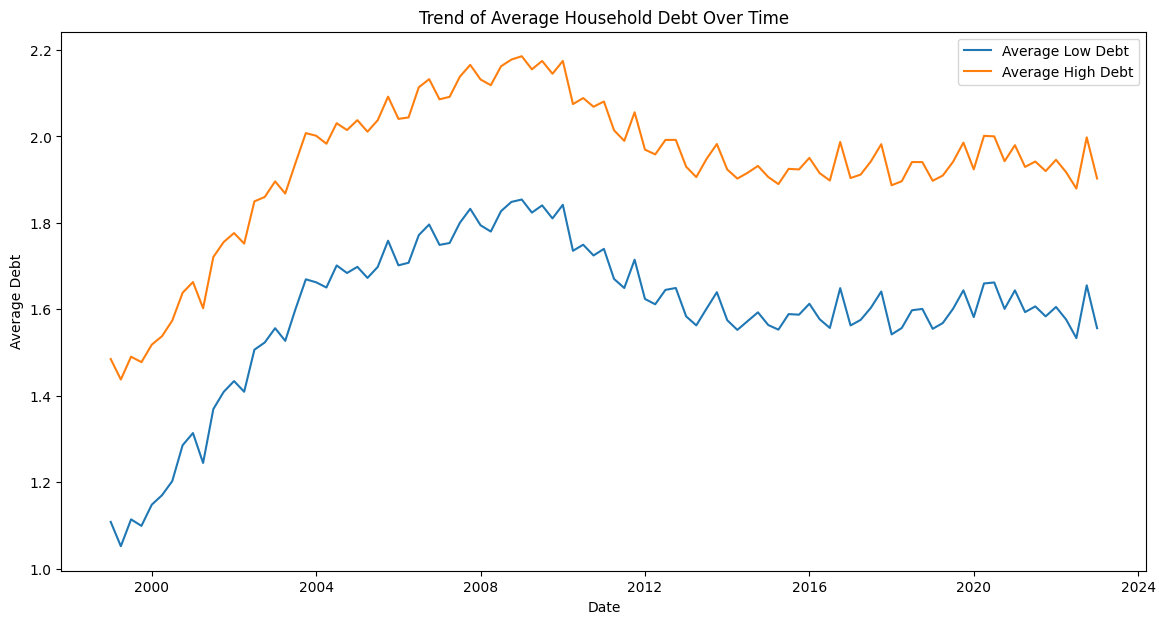

In [53]:
# Trend Analysis
average_debt_over_time = raw_debt_data.groupby('date').agg({'low': 'mean', 'high': 'mean'}).reset_index()
plt.figure(figsize=(14, 7))
plt.plot(average_debt_over_time['date'], average_debt_over_time['low'], label='Average Low Debt')
plt.plot(average_debt_over_time['date'], average_debt_over_time['high'], label='Average High Debt')
plt.title('Trend of Average Household Debt Over Time')
plt.xlabel('Date')
plt.ylabel('Average Debt')
plt.legend()
plt.show()

The trend plot shows the average low and high household debt values over time. Both series appear to follow a similar trend, which is expected given that the high values were filled using the low values for missing entries.

Although over time the trends are increasing we also see some seasonality may be occuring. Let's analyze to better understand the seasonality.

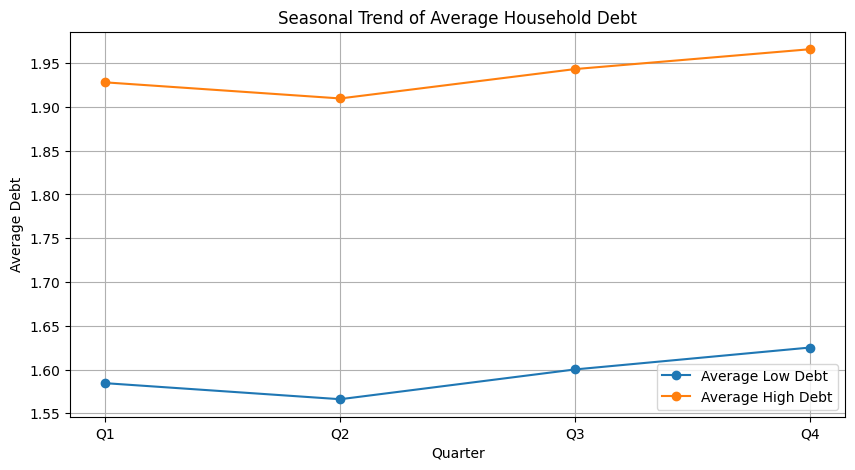

In [54]:
raw_debt_data['year'] = raw_debt_data['date'].dt.year
raw_debt_data['quarter'] = raw_debt_data['date'].dt.quarter
seasonal_debt = raw_debt_data.groupby('quarter').agg({'low': 'mean', 'high': 'mean'}).reset_index()
plt.figure(figsize=(10, 5))
plt.plot(seasonal_debt['quarter'], seasonal_debt['low'], marker='o', label='Average Low Debt')
plt.plot(seasonal_debt['quarter'], seasonal_debt['high'], marker='o', label='Average High Debt')
plt.title('Seasonal Trend of Average Household Debt')
plt.xlabel('Quarter')
plt.ylabel('Average Debt')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.grid(True)
plt.show()

The seasonal trend plot for average household debt shows the mean low and high values for each quarter. There doesn't appear to be significant fluctuations between quarters, suggesting that there may not be strong seasonality present in this aspect of the data.

Let's now search for any outliers.

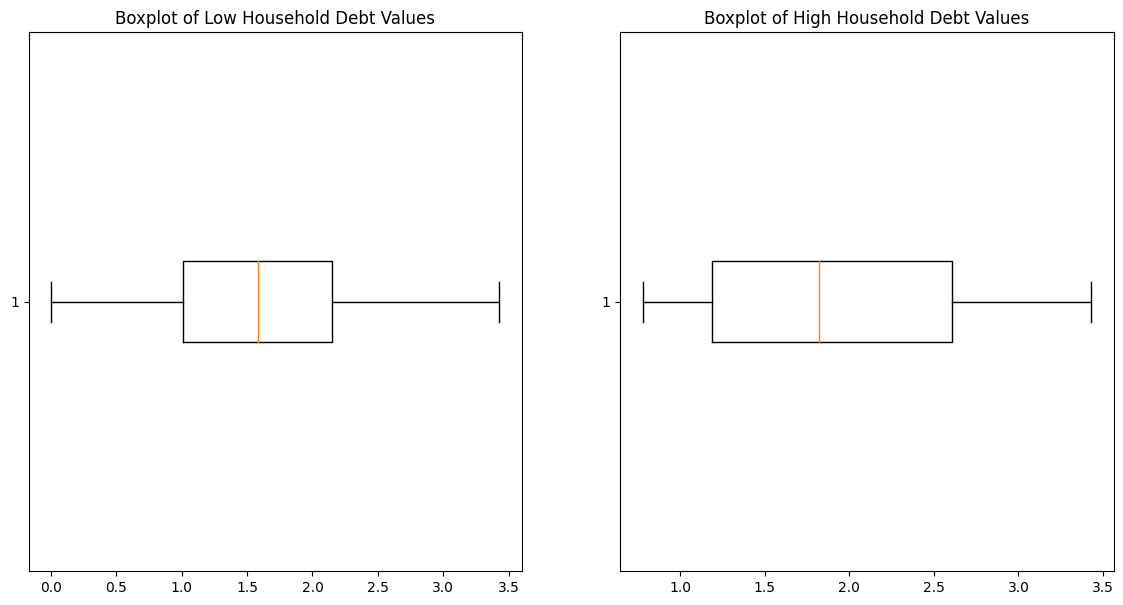

In [55]:
# Outlier Detection
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.boxplot(raw_debt_data['low'], vert=False)
plt.title('Boxplot of Low Household Debt Values')
plt.subplot(1, 2, 2)
plt.boxplot(raw_debt_data['high'], vert=False)
plt.title('Boxplot of High Household Debt Values')
plt.show()

The boxplots for the low and high household debt values indicate that there are some outliers present in both distributions. We also see that high has a higher variance than low.


Now that both datasets are clean we can begin the process of merging them. At this time in the process I will save the merge for Sprint 3 this is because I am still working through the process of converting the FIPS and ZIP to County Names. However with the data I have now I am able to run models on the datasets separately.

For Sprint 3 I will merge them.



### Models

At this time the FIPS codes will be enough to be able to identify each county. Let's do a time series model to better understand county household debt over time.


### Time Series Analysis



Let's start with aggregating our data by date

In [56]:
debt_aggregated = raw_debt_data.groupby('date').agg({'low': 'mean', 'high': 'mean'}).reset_index()

In [57]:
time_series_low = debt_aggregated.set_index('date')['low']
time_series_high = debt_aggregated.set_index('date')['high']
time_series= time_series_low + time_series_high

Let's decompose for the low column

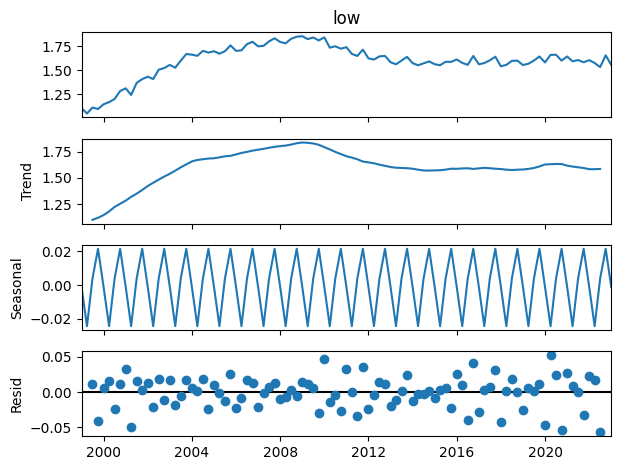

In [58]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series_low, model='additive', period=4)  # Quarterly data, hence period=4
decomposition.plot()
plt.show()

Here we see that there is seasonality found in our data and overall we see a peak in household debt increasing around 2008 and then somewhat decreasing and then plateauing for years after.

Let's decompose for high

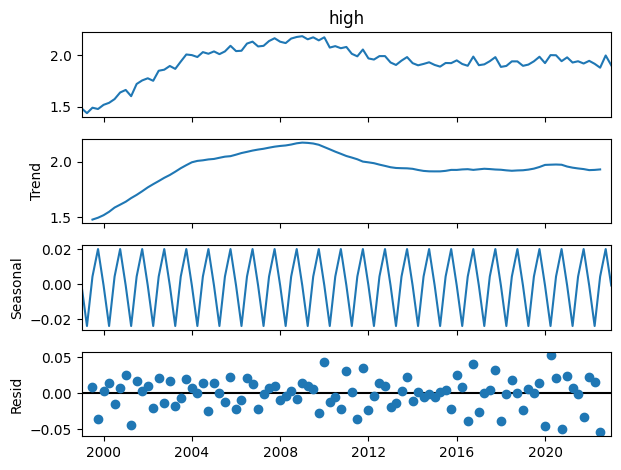

In [59]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series_high, model='additive', period=4)  # Quarterly data, hence period=4
decomposition.plot()
plt.show()

Here we see the same trend an increase in household debt around 2008 and then a drop and an evening out.

For our model we will use SARIMAX which is suitable for seasonal data like quarterly debt levels. First let's do a time series for the low debt column

We'll split the data into train and test(80/20). We will model 1999 - 2018 and leave the rest for predictions. Let's start with the low column.

In [78]:


# Group by both date and quarter, then aggregate
debt_aggregated = raw_debt_data.groupby(['date', 'quarter']).agg({'low': 'mean', 'high': 'mean'}).reset_index()

debt_aggregated

,date,quarter,low,high
0,1999-01-01,1,1.108425,1.485131
1,1999-04-01,2,1.052127,1.437746
2,1999-07-01,3,1.114237,1.490564
3,1999-10-01,4,1.099177,1.477857
4,2000-01-01,1,1.148284,1.518492
...,...,...,...,...
92,2022-01-01,1,1.605583,1.945962
93,2022-04-01,2,1.576525,1.917249
94,2022-07-01,3,1.533538,1.879445
95,2022-10-01,4,1.655653,1.997983


In [74]:
# Focus on 'low' debt for the analysis
time_series = debt_aggregated.set_index('date')['low']

split_point = debt_aggregated[debt_aggregated['date'].dt.year < 2018].index.max()
# Now, let's find the index representing 80% of the data up to that split point
split_index_80 = int(split_point * 0.8)
# Split the data
train = time_series.iloc[:split_index_80]
test = time_series.iloc[split_index_80:split_point]

AttributeError: ignored

In [62]:
# Fit a SARIMAX model to the training data
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 4))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Now that we've run the model let's do some predictions.

In [63]:
# Predict from the beginning of 2018 to the end of 2023
pred_start = '2018-01-01'
pred_end = '2023-12-31'
predictions = results.get_prediction(start=pd.to_datetime(pred_start), end=pd.to_datetime(pred_end), dynamic=True)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Let's plot the predictions now.

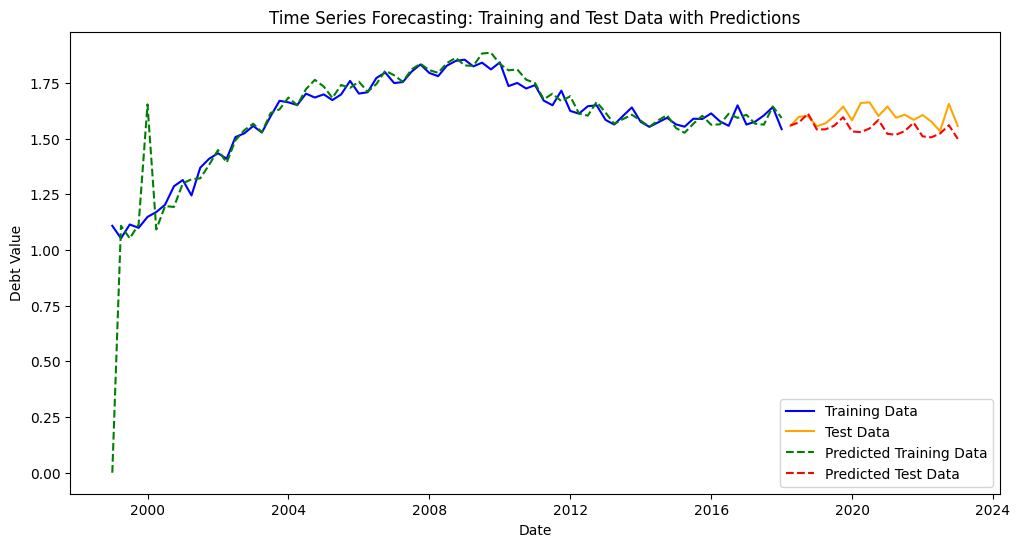

In [81]:
import matplotlib.pyplot as plt

# Plotting the observed data, the fit, and the forecast for both training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='orange')
plt.plot(train_predictions, label='Predicted Training Data', color='green', linestyle='--')
plt.plot(test_predictions, label='Predicted Test Data', color='red', linestyle='--')
plt.title('Time Series Forecasting: Training and Test Data with Predictions')
plt.xlabel('Date')
plt.ylabel('Debt Value')
plt.legend()
plt.show()



In [80]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Assuming raw_debt_data has been loaded, preprocessed, and split into train and test sets

# Fit the SARIMAX model on the training data
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
results = model.fit()

# Predict the training set
train_predictions = results.predict(start=train.index[0], end=train.index[-1])

# Predict the test set
test_predictions = results.predict(start=test.index[0], end=test.index[-1])

# Calculate MAE and MAPE for the training set
train_mae = mean_absolute_error(train, train_predictions)
train_mape = np.mean(np.abs((train - train_predictions) / train)) * 100

# Calculate MAE and MAPE for the test set
test_mae = mean_absolute_error(test, test_predictions)
test_mape = np.mean(np.abs((test - test_predictions) / test)) * 100

# Print the results
print(f'Training MAE: {train_mae}')
print(f'Training MAPE: {train_mape}%')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}%')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Training MAE: 0.0482945629164554
Training MAPE: 3.6504671403246816%
Test MAE: 0.0551989235411686
Test MAPE: 3.411125803650962%


## Next Steps


As for next steps I will process an intermediate dataset to help me convert the FIPS code to county Names and merge the datasets together so that I will be able to analyze, compare, and predict to answer our key question: How can household debt, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?


Now that we've run our base line models.My next steps are to tease out the more intricate patterns in the data, especially the non-linear relationships and interactions between features, I intend to deploy the Random Forest algorithm. I'll also use K-means clustering to categorize similar data points and employ mapping techniques for a visual representation of data patterns.

Concluding the analysis, I'll make predictions and carve out a strategy. Using my models, I aspire to predict the most promising locations for Target stores. Based on the insights from these models, I'll forge actionable strategies, such as identifying the best regions for new stores and spotlighting areas that might undergo notable financial shifts.

#Sprint 3

### Location Data Processing


Let's start the process of merging the data on location. First let's read in our converter tables. It contains the county name, zipcode, state and FIPS code.

In [ ]:
zip2fip = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/zip2fips.csv')
zip2fip.head()

Let's now create a column called ZIP in the Target dataset by extracting it from the Formatted Address Column

In [ ]:
# extract ZIP code
raw_target_data_drop3['ZIP'] = raw_target_data_drop3['Address.FormattedAddress'].str.extract(' (\d{5})').astype(int)
raw_target_data_drop3.head()


Let's also strip the word 'County' from the county name since the Target dataset only has the name in it ('Calhoun' vs 'Calhoun County')  

In [ ]:
zip2fip['COUNTYNAME'] = zip2fip['COUNTYNAME'].str.replace(' County', '', regex=False)
zip2fip.head()

In order to merge the columns on ZIP and County we will need to change the names of the columns so that they're matching.

In [ ]:
raw_target_data_drop3.rename(columns={'Address.County': 'COUNTYNAME'}, inplace=True)
raw_target_data_drop3.head()

In [ ]:
raw_target_data_drop3.duplicated(subset=['Address.FormattedAddress']).sum()